In [1]:
import numpy as np
import pandas as pd

from util import load_harps_spectrum
from whitening import apply_rad_vel, velocity_transform

%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
from harps_spec_info import harps_spec_info as spec_info
WAVE = spec_info.WAVE

In [3]:
harps_IDs = pd.read_csv('lists/HARPS-IDs.txt',header=None,names=['ID'])
harps_IDs

,ID
0,ADP.2014-09-16T11:03:30.940
1,ADP.2014-09-16T11:03:30.947
2,ADP.2014-09-16T11:03:30.973
3,ADP.2014-09-16T11:03:31.000
4,ADP.2014-09-16T11:03:31.007
...,...
267356,ADP.2019-04-19T01:13:31.386
267357,ADP.2019-04-19T01:13:31.388
267358,ADP.2019-04-19T01:13:31.390
267359,ADP.2019-04-19T01:13:31.392


In [4]:
# Load berv parameters
bervs = pd.read_csv('./public_harps_idps_berv.csv')

### Whitening

In [5]:
ids_to_test = harps_IDs.ID.values[range(1000,10000,100)] # The randomly selected spectra used in the publication

data_topo = []
data_randvel = []
for i,spec_ID in enumerate(ids_to_test):

    #-- Load the original spectrum
    w, data = load_harps_spectrum(specID=spec_ID,data_path='~/remote_epyc_data3/HARPS/fits/')
    
    #-- Apply the pre-processing steps (trimming, uniform wavelength grids) 
    _, flux = spec_info.preprocess(w, data)
    
    #-- Transform to the topo-centric frame
    berv = bervs[bervs['dp_id']==spec_ID]['kw_value'].values[0]
    w_topo, f_topo = apply_rad_vel(WAVE, flux, berv)
    data_topo.append(f_topo)
    
    #-- Emulate a random radial velocity, to increase the mutual entropy across various spectra
    max_vel = 30 # km/s
    randvel = np.random.uniform(-max_vel, max_vel)
    w_randvel, f_randvel = apply_rad_vel(w_topo, f_topo, randvel)
    data_randvel.append(f_randvel)
    
data_topo = np.array(data_topo)
data_randvel = np.array(data_randvel)

Visualize a sample spectrum (the last one in the loop) in the three reference frames

<IPython.core.display.Javascript object>


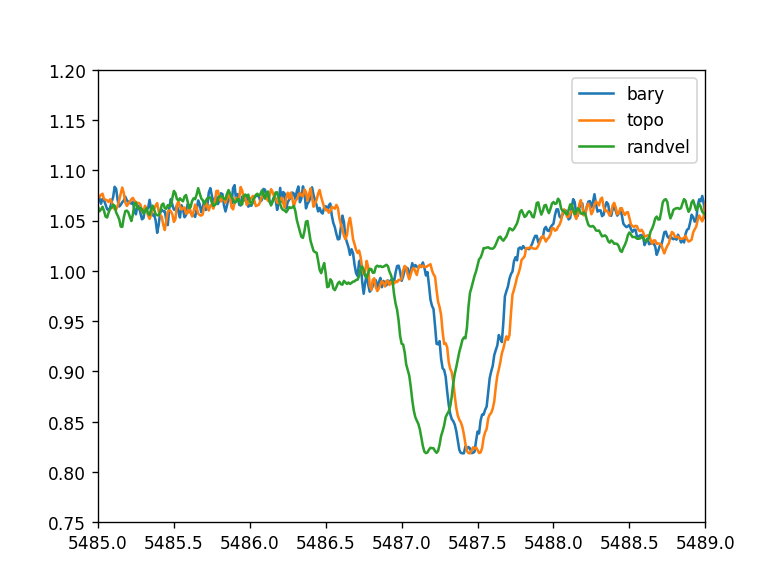

(0.75, 1.2)

In [6]:
plt.figure()
plt.plot(WAVE, flux, label='bary')
plt.plot(WAVE, f_topo, label='topo')
plt.plot(WAVE, f_randvel, label='randvel')
plt.legend()
plt.xlim(5485,5489)
plt.ylim(0.75,1.2)
    

<IPython.core.display.Javascript object>


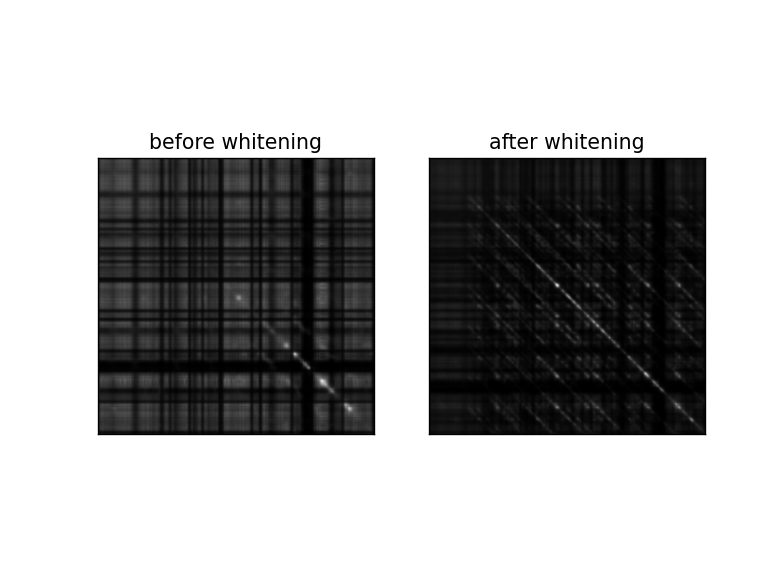

In [7]:
#---- Covariance Matrix
w = WAVE
ROI = (w>6275)&(w<6282)
cov1 = np.cov(data_topo[:,ROI].T)
cov2 = np.cov(data_randvel[:,ROI].T)

plt.figure()

ax1 = plt.subplot(121)
plt.imshow(cov1**4, cmap='gray')
plt.xticks([]);plt.yticks([])
plt.title('before whitening')

ax2 = plt.subplot(122)
plt.imshow(cov2**4, cmap='gray')
plt.xticks([]);plt.yticks([])
plt.title('after whitening')

plt.savefig(f'./covariance.png', bbox_inches='tight')
plt.show()